In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import torch.utils.data
import datetime
 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cpu')

In [2]:
train_data = datasets.CIFAR10("./data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10("./data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
stacked = torch.stack([train_data[i][0] for i in range(len(train_data))], dim=-1)
test_stacked = torch.stack([test_data[i][0] for i in range(len(test_data))], dim=-1)

In [5]:
mean = stacked.view(3, -1).mean(dim=1)
std = stacked.view(3, -1).std(dim=1)
train_data = datasets.CIFAR10("./data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]))

mean = test_stacked.view(3, -1).mean(dim=1)
std = test_stacked.view(3, -1).std(dim=1)
test_data = datasets.CIFAR10("./data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]))

Files already downloaded and verified
Files already downloaded and verified


In [6]:
cifar2 = [[data[0], 0 if data[1] == 0 else 1] for data in train_data if data[1] in [0, 2]]  # 0 airplane 1 bird
test_cifar2 = [[data[0], 0 if data[1] == 0 else 1] for data in test_data if data[1] in [0, 2]]  # 0 airplane 1 bird

In [7]:
cifar2_images = torch.zeros([len(cifar2), *cifar2[0][0].shape])
cifar2_labels = torch.zeros(len(cifar2))

for i in range(len(cifar2)):
    cifar2_images[i] = cifar2[i][0]
    cifar2_labels[i] = cifar2[i][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7869658..1.905926].


0

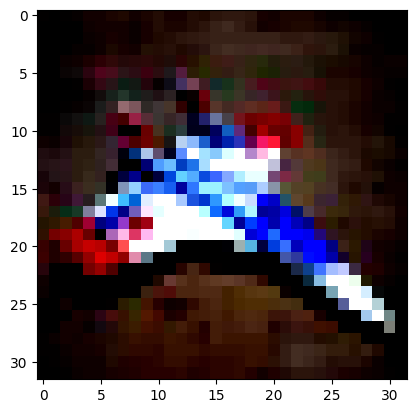

In [8]:
idx = 5
plt.imshow(cifar2[idx][0].permute(1, 2, 0))

cifar2[idx][1]

Start of convolutional network below

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8622148..2.0301533].


torch.Size([16, 30, 30])

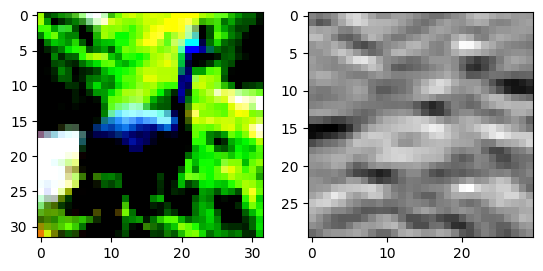

In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=0)
kernel_horiz = torch.tensor([
    [1/6, 1/6, 1/6],
    [0, 0, 0],
    [-1/6, -1/6, -1/6],
])
kernel_vert = torch.tensor([
    [-1/6, 0, 1/6],
    [-1/6, 0, 1/6],
    [-1/6, 0, 1/6],
])
kernel_diag = torch.tensor([
    [0, 0, -1/6],
    [0, 0, 0],
    [1/6, 0, 0],
])

with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = kernel_horiz


img = cifar2_images[0]
out = conv(img.unsqueeze(0))

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(out[0, 0].detach(), cmap='gray')


out[0].shape

In [10]:
pool = nn.MaxPool2d(2)
pooled_img = pool(img.unsqueeze(0)).shape

# pooled_out = conv(pooled_img)

# plt.imshow(pooled_img.permute(1,2,0))

In [26]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(8 * 8 * 8, 300),
            nn.Tanh(),

            nn.Linear(300, 200),
            nn.Sigmoid(),

            nn.Linear(200, 50),
            nn.Tanh(),

            nn.Linear(50, 2),
        )

    def forward(self, x):
        out = self.conv_layer(x)

        out = out.view(x.shape[0], -1)
        out = self.fc_layer(out)

        return out


model = Net()
model(img.unsqueeze(0))
# [p for p in model.parameters()]

tensor([[0.2266, 0.1787]], grad_fn=<AddmmBackward0>)

In [27]:
def training_loop(epochs, lr, momentum, lossFn, optimizer, data_loader):
    i = 0
    for epoch in range(epochs):
        for img_batch, label_batch in data_loader:
            predicted = model(img_batch)

            loss = lossFn(predicted, label_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i += 1

            if i % 200 == 0: print(f"{datetime.datetime.now()}, Epoch: {epoch}, Itteration: {i}, Loss: {loss}")

        
epochs = 100
lr = 0.1
momentum = 0

lossFn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr, momentum)

data_loader = torch.utils.data.DataLoader(cifar2, 128)

training_loop(epochs, lr, momentum, lossFn, optimizer, data_loader)

2024-09-06 07:38:07.237386, Epoch: 2, Itteration: 200, Loss: 0.4666004478931427
2024-09-06 07:38:15.606193, Epoch: 5, Itteration: 400, Loss: 0.36602815985679626
2024-09-06 07:38:23.938874, Epoch: 7, Itteration: 600, Loss: 0.41043174266815186
2024-09-06 07:38:32.039071, Epoch: 10, Itteration: 800, Loss: 0.3138907253742218
2024-09-06 07:38:40.222370, Epoch: 12, Itteration: 1000, Loss: 0.40148863196372986
2024-09-06 07:38:48.505544, Epoch: 15, Itteration: 1200, Loss: 0.33039963245391846
2024-09-06 07:38:56.572528, Epoch: 17, Itteration: 1400, Loss: 0.23892584443092346
2024-09-06 07:39:04.523040, Epoch: 20, Itteration: 1600, Loss: 0.3034014403820038
2024-09-06 07:39:12.771996, Epoch: 22, Itteration: 1800, Loss: 0.2888413071632385
2024-09-06 07:39:21.271545, Epoch: 25, Itteration: 2000, Loss: 0.1505616456270218
2024-09-06 07:39:29.921859, Epoch: 27, Itteration: 2200, Loss: 0.22163571417331696
2024-09-06 07:39:38.205413, Epoch: 30, Itteration: 2400, Loss: 0.16115811467170715
2024-09-06 07:39

In [28]:
test_data_loader = torch.utils.data.DataLoader(test_cifar2, 128)

correct = 0
total = 0
with torch.no_grad():
    for img_batch, label_batch in test_data_loader:
        with torch.no_grad():
            predicted = model(img_batch).argmax(dim=1)
            correct += (predicted == label_batch).sum()
            total += img_batch.shape[0]

print(f"Validation dataset accuracey: {correct / total * 100}%")

Validation dataset accuracey: 89.05000305175781%


In [29]:
torch.save(model.state_dict(), "./saved/birds_vs_airplanes.pt")

In [31]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load("./saved/birds_vs_airplanes.pt", weights_only=True))

<All keys matched successfully>

In [35]:
test_data_loader = torch.utils.data.DataLoader(test_cifar2, 128)

correct = 0
total = 0
with torch.no_grad():
    for img_batch, label_batch in test_data_loader:
        with torch.no_grad():
            predicted = loaded_model(img_batch).argmax(dim=1)
            correct += (predicted == label_batch).sum()
            total += img_batch.shape[0]

print(f"Validation dataset accuracey: {correct / total * 100}%")

Validation dataset accuracey: 89.05000305175781%
